## Imports

In [1]:
from collections import OrderedDict
from typing import List, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from datasets.utils.logging import disable_progress_bar
from torch.utils.data import DataLoader

import flwr
from flwr.client import Client, ClientApp, NumPyClient
from flwr.common import Metrics, Context
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import FedAvg
from flwr.simulation import run_simulation
from flwr_datasets import FederatedDataset

DEVICE = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Training on {DEVICE}")
print(f"Flower {flwr.__version__} / PyTorch {torch.__version__}")
disable_progress_bar()

/Users/hulkiciray/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/hulkiciray/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-03-06 00:32:58,316	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Training on mps
Flower 1.15.2 / PyTorch 2.6.0


## Loading Data
In this notebook, we introduce federated learning by training a simple convolutional neural network (CNN) on the popular CIFAR-10 dataset. We will also split the data into 10 partitions but in real world scenario, every client will have their own dataset so this won't be needed.

Each organization will act as a client in the federated learning system. Having ten organizations participate in a federation means having ten clients connected to the federated learning server.

We use the `flwr_datasets` library to partition the data. We will create a small training and test sets for each client and wrap each of these into a pytorch `DataLoader`.

In [2]:
NUM_CLIENTS = 10
BATCH_SIZE = 32

def load_datasets(partition_id: int):
    fds = FederatedDataset(dataset="cifar10", partitioners={"train": NUM_CLIENTS})
    partition = fds.load_partition(partition_id)
    partition_train_test = partition.train_test_split(test_size=0.2, seed=42) #Divide data on each node
    pytorch_transforms = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )

    def apply_transforms(batch):
        batch["img"] = [pytorch_transforms(img) for img in batch["img"]]
        return batch

    partition_train_test = partition_train_test.with_transform(apply_transforms)

    trainloader = DataLoader(
        partition_train_test["train"],
        batch_size=BATCH_SIZE,
        shuffle=True
    )

    valloader = DataLoader(
        partition_train_test["test"],
        batch_size=BATCH_SIZE,
        shuffle=False
    )

    testset = fds.load_split("test").with_transform(apply_transforms)
    testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

    return trainloader, valloader, testloader

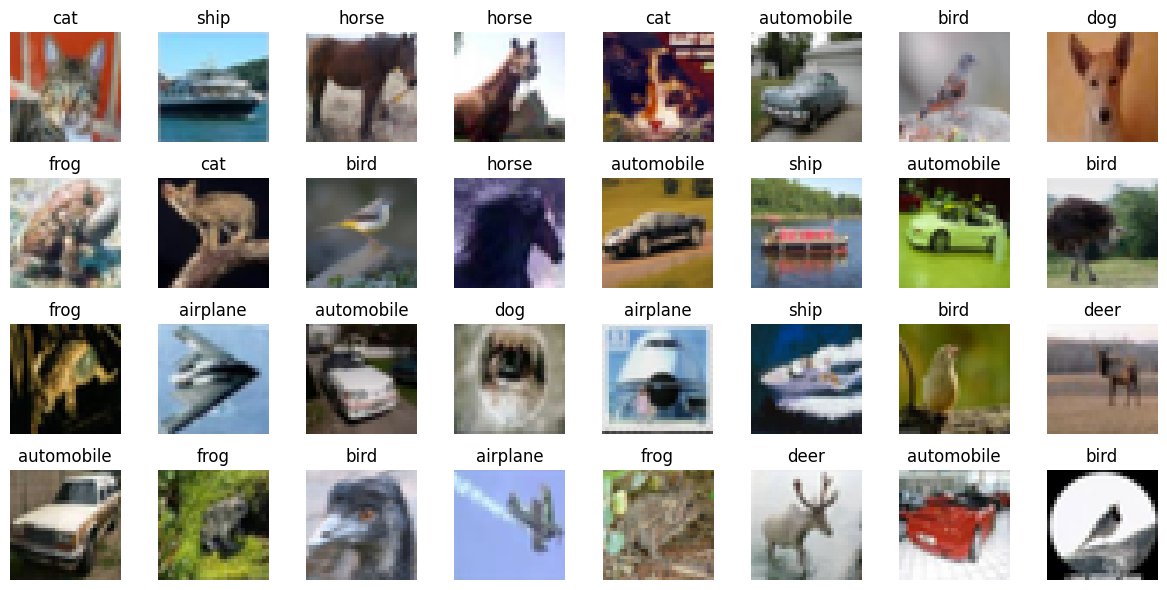

In [3]:
trainloader, _, _ = load_datasets(partition_id=0)
batch = next(iter(trainloader))
images, labels = batch["img"], batch["label"]
images = images.permute(0, 2, 3, 1).numpy()

images = images/2 + 0.5
fig, axs = plt.subplots(4, 8, figsize=(12, 6))
for i, ax in enumerate(axs.flat):
    ax.imshow(images[i])
    ax.set_title(trainloader.dataset.features["label"].int2str([labels[i]])[0])
    ax.axis("off")

fig.tight_layout()
plt.show()

## Centralized Training with PyTorch

We will first build traditional pytorch model.

In [4]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
def train(net, trainloader, epochs:int, verbose=False):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    for epoch in range(epochs):
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in enumerate(trainloader, 0):
            #inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            epoch_loss += loss
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        if verbose:
            print(f"Epoch {epoch+1}: train loss {epoch_loss}, accuracy {epoch_acc}")


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for batch in testloader:
            images, labels = batch["img"].to(DEVICE), batch["label"].to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [6]:
trainloader, valloader, testloader = load_datasets(partition_id=0)
net = Net().to(DEVICE)

for epoch in range(5):
    train(net, trainloader, 1)
    loss, accuracy = test(net, valloader)
    print(f"Epoch {epoch+1}: validation loss {loss}, accuracy {accuracy}")

loss, accuracy = test(net, testloader)
print(f"Final test set performance:\n\tloss {loss}\n\taccuracy {accuracy}")

Epoch 1: validation loss 0.6782835731506348, accuracy 0.118
Epoch 2: validation loss 0.9049129581451416, accuracy 0.12
Epoch 3: validation loss 0.9235418796539306, accuracy 0.129
Epoch 4: validation loss 1.1277896995544434, accuracy 0.127
Epoch 5: validation loss 1.261747268676758, accuracy 0.119
Final test set performance:
	loss 1.1926115758895874
	accuracy 0.1313


## FL with Flower

Steps
1. The server sends global model parameters to the clients
2. Clients update the model parameters received from the global model
3. Clients train the model on their own data
4. Clients send the updated parameters (or alternatively gradients) to the server

#### Update Model Parameters

In [7]:
def set_parameters(net, parameters: List[np.ndarray]):
    """This is a helper function to update local parameters with the global ones."""
    params_dict = zip(net.state_dict().keys(), parameters) # `state_dict to access PyTorch model parameter tensors
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)

def get_parameters(net) -> List[np.ndarray]:
    """This is another helper function to get the server model"""
    return [val.cpu().numpy() for _, val in net.state_dict().items()]

#### Define the Flower ClientApp
We create a `ServerApp` and a `ClientApp` to run the server-side and client-side actions.

In [8]:
class FlowerClient(NumPyClient):
    def __init__(self, net, trainloader, valloader):
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        """Return the current local model parameters"""
        return get_parameters(self.net)

    def fit(self, parameters, config):
        """Receive model parameters from the server, train the model on the local data, and return the updated model parameters to the server"""
        set_parameters(self.net, parameters)
        train(self.net, self.trainloader, epochs=1)
        return get_parameters(self.net), len(self.trainloader.dataset), {}

    def evaluate(self, parameters, config):
        """Receive model parameters from the server, evaluate the model on the local data, and return the evaluation result to the server"""
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}

#### Important Information

In this notebook, we want to simulate a federated learning system with 10 clients on a single machine. This means that the server and all 10 clients will live on a single machine and share resources such as CPU, GPU, and memory. Having 10 clients would mean having 10 instances of FlowerClient in memory. Doing this on a single machine can quickly **exhaust the available memory** resources, even if only a subset of these clients participates in a single round of federated learning.

In addition to the regular capabilities where server and clients run on multiple machines, Flower, therefore, provides special simulation capabilities that create `FlowerClient` instances only when they are actually necessary for training or evaluation. To enable the Flower framework to create clients when necessary, **we need to implement a function that creates a FlowerClient instance on demand. We typically call this function `client_fn.`** Flower calls client_fn whenever it needs an instance of one particular client to call fit or evaluate (those instances are usually discarded after use, so they should not keep any local state). In federated learning experiments using Flower, **clients are identified by a partition ID, or partition-id.** This partition-id is used to load different local data partitions for different clients, as can be seen below. The value of partition-id is retrieved from the node_config dictionary in the Context object, which holds the information that persists throughout each training round.

**❕❗️With this, we have the class `FlowerClient` which defines client-side training/evaluation and `client_fn` which allows Flower to create `FlowerClient` instances whenever it needs to call fit or evaluate on one particular client.**

In [9]:
def client_fn(context: Context) -> Client:
    """Create a Flower client representing a single organization."""
    net = Net().to(DEVICE)
    partition_id = context.node_config["partition_id"]
    trainloader, valloader, _ = load_datasets(partition_id=partition_id)

    # Create a single Flower client representing a single organization
    # FlowerClient is a subclass of NumPyClient, so we need to call .to_client()
    # to convert it to a subclass of `flwr.client.Client`
    return FlowerClient(net, trainloader, valloader).to_client()

# Create the ClientApp
client = ClientApp(client_fn=client_fn)

#### Define the Flower ServerApp
On the server side, we need to configure a strategy which encapsulates the federated learning approach/algorithm, for example, Federated Averaging (FedAvg)

In [29]:
# Let's create FedAvg strategy
strategy = FedAvg(
    fraction_fit=1.0, # Sample 100% of available clients for training
    fraction_evaluate=0.5, # Sample 50% of available clients for evaluation
    min_fit_clients=10, # Never sample less than 10 clients for training
    min_evaluate_clients=5, # Never sample less than 5 clients for evaluation
    min_available_clients=10 # Wait until all 10 clients are available
)

Similar to `ClientApp`, we create a `ServerApp` using a utility function `server_fn`. In `server_fn`, we pass an instance of `ServerConfig` for defining the number of federated learning rounds (`num_rounds`) and we also pass the previously created `strategy`. The `server_fn` returns a `ServerAppComponents` object containing the settings that define the `ServerApp` behaviour. `ServerApp` is the entrypoint that Flower uses to call all your server-side code (for example, the strategy)

In [30]:
def server_fn(context: Context) -> ServerAppComponents:
    config = ServerConfig(num_rounds=5)
    return ServerAppComponents(strategy=strategy, config=config)

# Create the ServerApp
server = ServerApp(server_fn=server_fn)

#### Run the Training

In simulation, we often want to control the amount of resources each client can use. In the next cell, we specify a `backend_config` dictionary with the `client_resources` key (required) for defining the amount of CPU and GPU resources each client can access.

In [31]:
# By default, each client will be allocated 1x CPU and 0x GPUs
backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 0.0}}

# When running on GPU, assign an entire GPU for each client
if DEVICE == "mps": # use "cuda" for linux
    backend_config = {"client_resources": {"num_cpus": 1, "num_gpus": 1.0}}

In [32]:
run_simulation(
    server_app=server,
    client_app=client,
    num_supernodes=NUM_CLIENTS,
    backend_config=backend_config
)

INFO :      Starting Flower ServerApp, config: num_rounds=5, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
ERROR :     An exception occured!! ActorPool is empty. Stopping Simulation. Check `num_cpus` and/or `num_gpus` passed to the simulation engine
ERROR :     Traceback (most recent call last):
  File "/Users/hulkiciray/Library/Python/3.9/lib/python/site-packages/flwr/server/superlink/fleet/vce/vce_api.py", line 193, in run_api
    backend.build(app_fn)
  File "/Users/hulkiciray/Library/Python/3.9/lib/python/site-packages/flwr/server/superlink/fleet/vce/backend/raybackend.py", line 137, in build
    raise ex
  File "/Users/hulkiciray/Library/Python/3.9/lib/python/site-packages/flwr/server/superlink/fleet/vce/backend/raybackend.py", line 131, in build
    self.pool = BasicActorPool(
  File "/Users/hulkiciray/Library/Python/3.9/lib/python/site-packages/flwr/simulation/ray_transport/ray_actor.py", line 427, in __init__
 

RuntimeError: Exception in ServerApp thread